# Mandatory Assignment 1

#### Part I: Multi-layer Perceptron

***

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebook**: [material/nns_pytorch.ipynb](material/nns_pytorch.ipynb)

Table of contents:
1. Activate GPU
2. Load data
3. Inspect data
4. Artificial neural network (**Where you will implement the ANN**)
5. Training hyperparameters (**Where you will add training parameters**)
6. Training
7. Plot loss and accuracy
8. Evaluate


In [ ]:
import random
import matplotlib.pyplot as plt
import os
from pathlib import Path

import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F 

First, a bit of a hack in case your IDE wants to run the notebook from /`assignment/` and not the project root folder `/ma1`. We need the working directory to be `/ma1` for local imports to work.

In [ ]:
while Path.cwd().name != "ma1" and "ma1" in str(Path.cwd()):
    os.chdir("..")  
print(f"Working directory set to: {Path.cwd()}")

Working directory set to: c:\Users\Alexandru Plecan\Desktop\Bewerbung\Studium\BWL\Master\AIML25\ma1


##### Import local files

To declutter the notebooks, your are given a module (`/src`) of useful functions. Please study each one as they contain important code (particularly `src.training` and `src.evaluation`). 

In [ ]:
from src.utils import get_device
from src.data import load_torch_data, to_dataloader, train_val_split
from src.training import fit
from src.evaluation import evaluate
from src.visualize import plot_training_history

### 1. Activate GPU
If available. Note that this is not necessary, but it will speed up your training.

In [ ]:
DEVICE = get_device()


Running pytorch version (2.5.1) with backend = cpu


### 2. Load data

In [ ]:
train_val = load_torch_data(
    dataset="MNIST",
    root = 'data',                     
    download = True,                   
    train = True,                      
    transform = transforms.ToTensor()  
)

test = load_torch_data(
    dataset = "MNIST",
    root = 'data',
    download = True,
    train = False,
    transform = transforms.ToTensor()
)

f"{len(train_val)=}, {len(test)=}"

'len(train_val)=60000, len(test)=10000'

In [ ]:
train, val = train_val_split(train_val, val_ratio=0.2, seed=42)

f"{len(val)=}, {len(train)=}"

'len(val)=12000, len(train)=48000'

In [ ]:
train_loader = to_dataloader(train, batch_size = 64, shuffle = True)
val_loader = to_dataloader(val, batch_size = 64, shuffle = False)
test_loader = to_dataloader(test, batch_size = 64, shuffle = False)

### 3. Inspect data

Default image shape: torch.Size([1, 28, 28])
Reshaped image shape: torch.Size([28, 28])
Total pixels: 784
The label for this image: 5


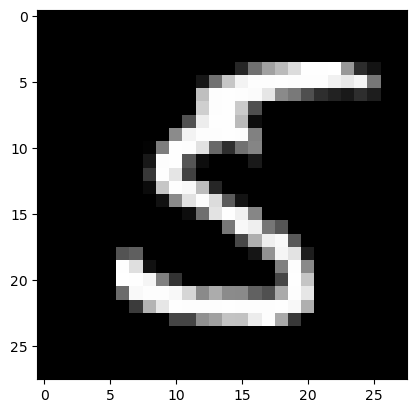

In [ ]:
selection = random.randrange(len(train)-1)
image, label = train[selection]

print(f"Default image shape: {image.shape}")
image = image.view([28,28])

print(f"Reshaped image shape: {image.shape}")
plt.imshow(image, cmap="gray")

print(f"Total pixels: {image.shape[0] * image.shape[1]}")

print(f"The label for this image: {label}")


***

### 4. Artificial neural network

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
     
        self.flatten = nn.Flatten()
     
        self.fc1 = nn.Linear(28 * 28, 500)
      
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
      # Added a dropout layer as we discussed possible overfitting. I believe didnt chage that much but I think it is a good practice to add it.
        self.fc2 = nn.Linear(500, 10)
    
    def forward(self, x: torch.Tensor):
       
        x = self.flatten(x)
        
        x = self.fc1(x)
       
        x = self.relu(x)
      
        x = self.fc2(x)
        return x


### 5. Training hyperparameters

In [20]:
LR = 0.01         
NUM_EPOCHS = 30    
BATCH_SIZE = 64 # Apparently my CPU can't handle it. I added the batch size to reduce the load on the CPU.
criterion = nn.CrossEntropyLoss()  


Instantiate the model and optimizer

In [ ]:
model = MLP().to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=LR)


In [22]:
model

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

### 6. Training

In [23]:
model, history = fit(
    model,
    train_loader = train_loader,
    val_loader = val_loader,
    device = DEVICE,
    optimizer = optimizer,
    criterion = criterion,
    num_epochs = NUM_EPOCHS
)

Epoch [1/30]: Train Loss: 1.3094 | Train Accuracy: 75.63% | Val Loss: 0.6792 | Val Accuracy: 84.77%
Epoch [2/30]: Train Loss: 0.5351 | Train Accuracy: 87.04% | Val Loss: 0.4656 | Val Accuracy: 88.06%
Epoch [3/30]: Train Loss: 0.4149 | Train Accuracy: 89.00% | Val Loss: 0.4008 | Val Accuracy: 89.13%
Epoch [4/30]: Train Loss: 0.3671 | Train Accuracy: 89.92% | Val Loss: 0.3688 | Val Accuracy: 89.72%
Epoch [5/30]: Train Loss: 0.3397 | Train Accuracy: 90.56% | Val Loss: 0.3475 | Val Accuracy: 90.26%
Epoch [6/30]: Train Loss: 0.3201 | Train Accuracy: 90.89% | Val Loss: 0.3326 | Val Accuracy: 90.39%
Epoch [7/30]: Train Loss: 0.3048 | Train Accuracy: 91.40% | Val Loss: 0.3183 | Val Accuracy: 90.95%
Epoch [8/30]: Train Loss: 0.2920 | Train Accuracy: 91.70% | Val Loss: 0.3072 | Val Accuracy: 91.33%
Epoch [9/30]: Train Loss: 0.2806 | Train Accuracy: 92.09% | Val Loss: 0.2973 | Val Accuracy: 91.60%
Epoch [10/30]: Train Loss: 0.2704 | Train Accuracy: 92.40% | Val Loss: 0.2889 | Val Accuracy: 91.83%

### 7. Plot loss and accuracy

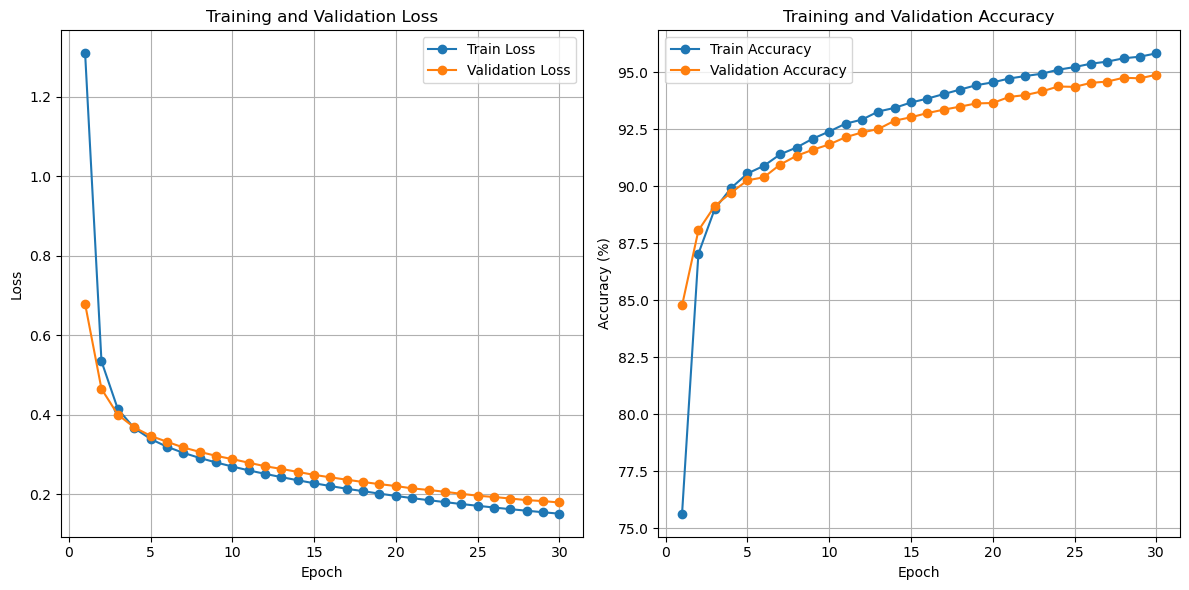

In [24]:
plot_training_history(history)

### 8. Evaluate

In [ ]:
evaluate(
    model = model,
    data_loader = train_loader,  
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.1487, Accuracy: 95.90%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4735
           1       0.97      0.98      0.97      5383
           2       0.96      0.95      0.96      4762
           3       0.96      0.94      0.95      4886
           4       0.95      0.96      0.95      4681
           5       0.95      0.95      0.95      4368
           6       0.97      0.97      0.97      4752
           7       0.96      0.97      0.97      4983
           8       0.95      0.94      0.95      4674
           9       0.95      0.94      0.94      4776

    accuracy                           0.96     48000
   macro avg       0.96      0.96      0.96     48000
weighted avg       0.96      0.96      0.96     48000



In [ ]:
evaluate(
    model = model,
    data_loader = val_loader,  
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.1823, Accuracy: 94.78%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1188
           1       0.97      0.97      0.97      1359
           2       0.95      0.93      0.94      1196
           3       0.93      0.94      0.93      1245
           4       0.94      0.95      0.94      1161
           5       0.93      0.95      0.94      1053
           6       0.96      0.96      0.96      1166
           7       0.95      0.97      0.96      1282
           8       0.95      0.94      0.95      1177
           9       0.93      0.90      0.91      1173

    accuracy                           0.95     12000
   macro avg       0.95      0.95      0.95     12000
weighted avg       0.95      0.95      0.95     12000



In [ ]:
evaluate(
    model = model,
    data_loader = test_loader,  
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.1573, Accuracy: 95.48%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.96      0.95      0.95      1032
           3       0.94      0.95      0.95      1010
           4       0.94      0.96      0.95       982
           5       0.95      0.94      0.95       892
           6       0.96      0.96      0.96       958
           7       0.95      0.95      0.95      1028
           8       0.95      0.94      0.94       974
           9       0.95      0.93      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

